In [2]:
import random
from pathlib import Path
import matplotlib.pyplot as plt

from glob import glob
import numpy as np
import torch
from omegaconf import OmegaConf
import models
from itertools import product
from data import FieldData, LazyDataset
from torch.utils.data import DataLoader
from torch import nn
from utils import seed_all
from tqdm  import tqdm
from itertools import product
from neuralop import LpLoss
from neuralop.datasets.tensor_dataset import TensorDataset

from data import get_field

In [5]:
log_dir = '/home/anthony/EM-neuraloperator/result/h1/1000-50-4'
model_dir = log_dir + '/model-final.pt'
cfg = OmegaConf.load(log_dir + '/.hydra/config.yaml')
model = getattr(models, cfg.model)(**cfg.model_config)
model.load_state_dict(torch.load(model_dir, map_location=torch.device('cpu')))
model.eval()
seed_all(cfg.seed)

1774


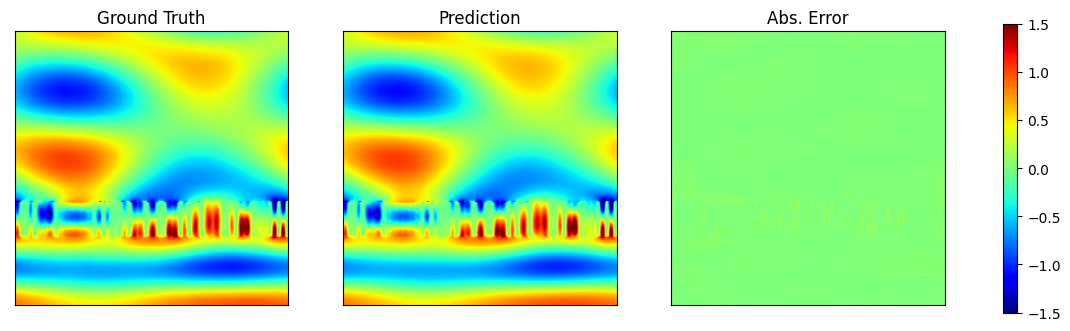

In [161]:
model = model.to('cuda:0')
idx = random.randint(0, 2000)
with torch.no_grad():
    out = model(x=test_ds[idx]['x'].unsqueeze(0).to('cuda:0')).detach().cpu()
y = test_ds[idx]['y'].unsqueeze(0)

v = 1.5
vmin = -v
vmax = v

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
axes[0].imshow(out[0][0], cmap='jet', vmin=vmin, vmax=vmax)
axes[0].set_title('Ground Truth')
axes[0].set_xticks([], [])
axes[0].set_yticks([], [])

axes[1].imshow(y[0][0], cmap='jet', vmin=vmin, vmax=vmax)
axes[1].set_title('Prediction')
axes[1].set_xticks([], [])
axes[1].set_yticks([], [])

error = (y[0][0]-out[0][0]).abs()
im = axes[2].imshow(error, cmap='jet', vmin=vmin, vmax=vmax)
axes[2].set_title('Abs. Error')
axes[2].set_xticks([], [])
axes[2].set_yticks([], [])

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.25)

plt.show()